### 데이터 불러오기

In [5]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *



In [3]:
DATAPATH = '/home/wagyu0923/project/commuting_happiness/data/2024 서울서베이 가구원_data_코드북.xlsx'
excel_data = pd.read_excel(DATAPATH, sheet_name = 0)


### 데이터 전처리

In [36]:
# 사용할 변수들만 걸러내기
using_cols = [# 핵심 변수
    'Q34',      # 지난 2주간 스트레스
    'Q20',      # 통근/통학 여부
    'Q20C1',     # 통근/통학 시간_시간
    'Q20C2',     # 통근/통학 시간_분

    #  통제변수 - 개인 특성
    'SQ1_2',     # 성별
    'SQ1_3',     # 출생연도 
    'SQ1_4',     # 혼인상태
    'SQ1_7',     # 등록장애인 여부

    # 통제변수 - 가구/소득
    'FAM1',      # 전체가구원수
    'AQ1',       # 월평균 가구소득

    # 통제변수 - 교육/직업/노동
    'DQ1',       # 학력
    'DQ3A',      # 고용형태
    'DQ3B1',     # 주당 평균 근로시간_시간
    'DQ3B2',     # 주당 평균 근로시간_분

    # 통제변수 - 주거/지역
    'GU',        # 거주지 구코드
    'SQ0_2',     # 주택형태
    'SQ0_3',     # 주거점유형태
]

raw_df = excel_data.copy()[using_cols]

In [37]:
rename_dict = {
    'Q34': 'Stress_Level',           
    'Q20': 'Commute_Status',           
    'Q20C1': 'Commute_Hour',        
    'Q20C2': 'Commute_Min',           
    'SQ1_2': 'Gender',                 
    'SQ1_3': 'Birth_Year',            
    'SQ1_4': 'Marital_Status',        
    'SQ1_7': 'Disabled_Reg',          
    'FAM1': 'Household_Size',         
    'AQ1': 'Household_Income',         
    'DQ1': 'Education',                            
    'DQ3A': 'Employment_Type',         
    'DQ3B1': 'Work_Hours_Week',        
    'DQ3B2': 'Work_Mins_Week',               
    'GU': 'District_Code',             
    'SQ0_2': 'House_Type',            
    'SQ0_3': 'House_Occupancy',         
}

raw_df = raw_df.rename(columns=rename_dict)

In [42]:
print('결측치 제거 전 행 수:' ,len(raw_df))
mid_df = raw_df.copy().dropna()
print('결측치 제거 후 행 수:' ,len(mid_df))

# 시간 단위로 변환
mid_df['Commute_Time'] = (mid_df['Commute_Hour']*60 + mid_df['Commute_Min'])/60
mid_df['Work_Time'] = (mid_df['Work_Hours_Week']*60 + mid_df['Work_Mins_Week'])/60

# 출생년도로부터 나이 도출
mid_df['Age'] = 2024 - mid_df['Birth_Year']

# 남성 0, 여성 1로 변경
mid_df['Gender'] = mid_df['Gender'].replace({1: 0, 2: 1})
mid_df['Disabled_Reg'] = mid_df['Disabled_Reg'].replace({1 : 1, 2 : 0})
# 자가 소유 외의 주거 점유 형태를 0으로 통일 
mid_df['House_Occupancy'] = mid_df['House_Occupancy'].replace({1 : 1, 2 : 0, 3 : 0, 4 : 0, 5 : 0, 6 : 0 })


결측치 제거 전 행 수: 36280
결측치 제거 후 행 수: 24707


In [45]:
not_use_anymore = ['Commute_Status', 'Commute_Hour','Commute_Min', 'Birth_Year', 'Work_Hours_Week', 'Work_Mins_Week']
later_df = mid_df.copy().drop(columns = not_use_anymore)

In [46]:
# 연속형 변수 중심화
cols_to_cent = ['Household_Income','Commute_Time','Work_Time', 'Age']
df_final = later_df.copy()
for col in cols_to_cent:
    mean = later_df[col].mean()
    df_final[col] = later_df[col]-mean

In [47]:
df_final.describe()

,Stress_Level,Gender,Marital_Status,Disabled_Reg,Household_Size,Household_Income,Education,Employment_Type,District_Code,House_Type,House_Occupancy,Commute_Time,Work_Time,Age
count,24707.000000,24707.000000,24707.000000,24707.000000,24707.000000,2.470700e+04,24707.000000,24707.000000,24707.000000,24707.000000,24707.000000,2.470700e+04,2.470700e+04,2.470700e+04
mean,3.135103,0.419031,1.589630,0.004938,2.394908,-1.137697e-15,5.139717,2.008419,436.216457,2.201522,0.510786,5.169387e-17,2.266190e-16,-9.185549e-16
std,0.911511,0.493410,1.024872,0.070098,0.996267,4.264721e+00,0.972954,1.779793,179.973640,0.935109,0.499894,2.939545e-01,7.943407e+00,1.332135e+01
min,1.000000,0.000000,1.000000,0.000000,1.000000,-1.099980e+01,1.000000,1.000000,110.000000,1.000000,0.000000,-5.417392e-01,-4.049884e+01,-3.010580e+01
25%,2.000000,0.000000,1.000000,0.000000,2.000000,-2.999798e+00,4.000000,1.000000,290.000000,2.000000,0.000000,-2.250725e-01,-2.498838e+00,-1.210580e+01
50%,3.000000,0.000000,1.000000,0.000000,2.000000,2.023718e-04,5.000000,1.000000,440.000000,2.000000,1.000000,-5.840585e-02,-2.498838e+00,-1.058000e-01
75%,4.000000,1.000000,2.000000,0.000000,3.000000,3.000202e+00,6.000000,2.000000,590.000000,3.000000,1.000000,1.082608e-01,2.501162e+00,1.089420e+01
max,5.000000,1.000000,5.000000,1.000000,8.000000,9.000202e+00,7.000000,7.000000,740.000000,4.000000,1.000000,1.941594e+00,1.245012e+02,4.089420e+01


### 매칭 전 결과

In [48]:
model = smf.ols(
    "Stress_Level ~ Gender + C(Marital_Status) + Disabled_Reg + Household_Size + Household_Income + Education + C(Employment_Type)+ C(District_Code) +  C(House_Type) + House_Occupancy +Commute_Time + Commute_Time:House_Occupancy + Work_Time + Age",
    data = df_final
).fit(cov_type='cluster', cov_kwds={'groups': df_final['District_Code']})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Stress_Level   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     866.1
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           8.57e-30
Time:                        03:04:42   Log-Likelihood:                -32163.
No. Observations:               24707   AIC:                         6.442e+04
Df Residuals:                   24659   BIC:                         6.481e+04
Df Model:                          47                                         
Covariance Type:              cluster                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

/home/wagyu0923/miniconda3/envs/commuting/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 23
  warnings.warn('covariance of constraints does not have full '


### 매칭

In [49]:
def smd(x_treat, x_control):
    mu_t = np.mean(x_treat)
    mu_c = np.mean(x_control)
    sd_t = np.std(x_treat, ddof = 1)
    sd_c = np.std(x_control, ddof = 1)
    pooled_sd = np.sqrt((sd_t**2 + sd_c**2) / 2)
    return (mu_t - mu_c) / pooled_sd if pooled_sd > 0 else 0

def compute_balance(df, num_vars, cat_vars,treat_col = 'House_Occupancy'):
    treated = df[df[treat_col]==1].copy()
    control = df[df[treat_col]==0].copy()

    rows = []
    for num_var in num_vars:
        smd_val = smd(treated[num_var], control[num_var])
        rows.append([
            num_var,
            treated[num_var].mean(),
            control[num_var].mean(),
            smd_val
        ])

    for cat_var in cat_vars:
        categories = df[cat_var].unique()
        for cat in categories:
            t_binary = (treated[cat_var] == cat).astype(int)
            c_binary = (control[cat_var] == cat).astype(int)
            smd_val = smd(t_binary, c_binary)
            
            rows.append([
                f"{cat_var}_{cat}",
                t_binary.mean(),
                c_binary.mean(),
                smd_val
            ]
            )

    return pd.DataFrame(rows, columns = ["variable", "mean_treat", 'mean_control', 'SMD'])

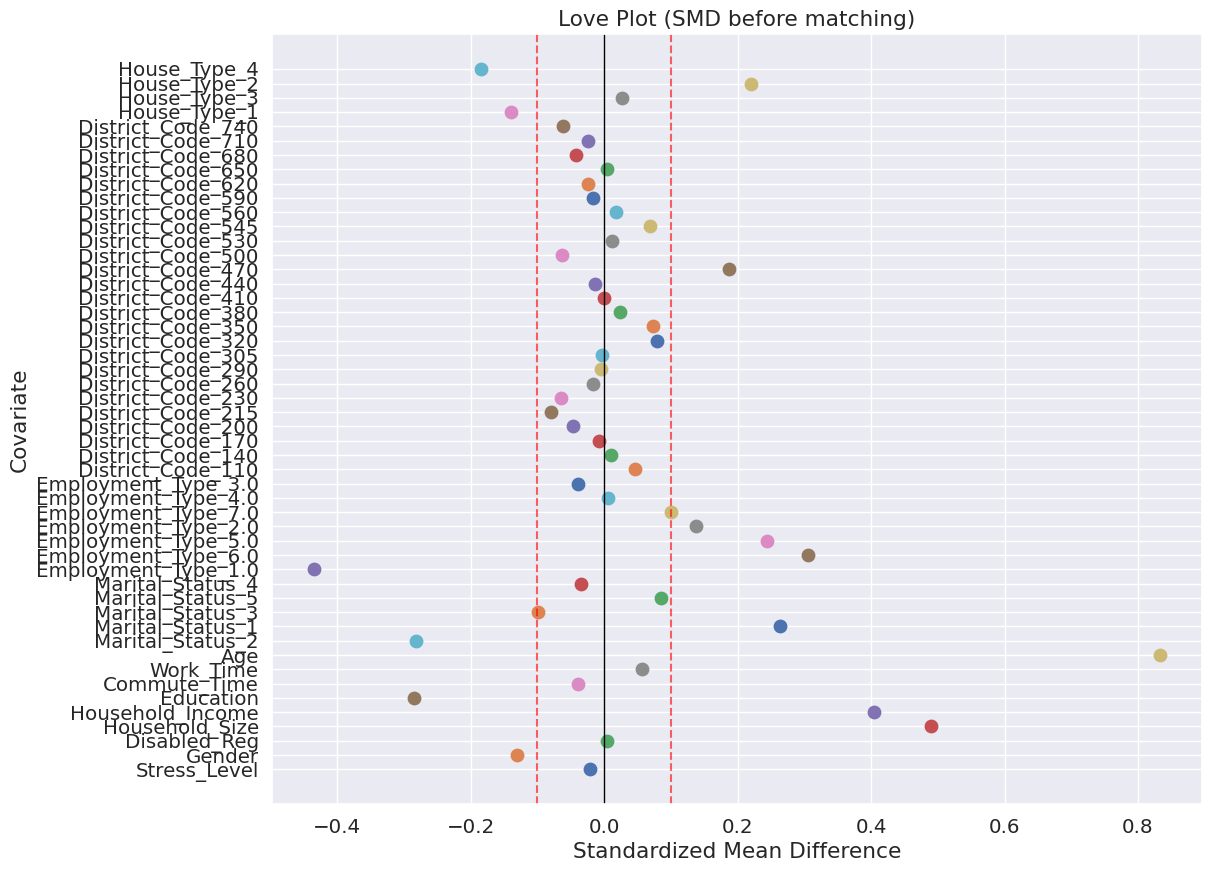

In [50]:
# 매칭 전 SMD 값
num_vars = ['Stress_Level', 'Gender', 'Disabled_Reg', 'Household_Size', 'Household_Income','Education', 'Commute_Time', 'Work_Time','Age']
cat_vars = ['Marital_Status', 'Employment_Type', 'District_Code', 'House_Type']
smd_output = compute_balance(df_final, num_vars, cat_vars)

plt.figure(figsize=(12,10))
plt.axvline(0, color='black', linewidth=1)
for i, row in smd_output.iterrows():
    plt.scatter(row["SMD"], row["variable"], s=80)

plt.axvline(0.1, color='red', linestyle='--', alpha=0.6)
plt.axvline(-0.1, color='red', linestyle='--', alpha=0.6)
plt.title("Love Plot (SMD before matching)")
plt.xlabel("Standardized Mean Difference")
plt.ylabel("Covariate")
plt.show()

In [51]:
smd_output[abs(smd_output['SMD'])>=0.1]['variable']

1                  Gender
3          Household_Size
4        Household_Income
5               Education
8                     Age
9        Marital_Status_2
10       Marital_Status_1
14    Employment_Type_1.0
15    Employment_Type_6.0
16    Employment_Type_5.0
17    Employment_Type_2.0
18    Employment_Type_7.0
35      District_Code_470
46           House_Type_1
48           House_Type_2
49           House_Type_4
Name: variable, dtype: object

In [65]:
df_psm = df_final.copy()
df_psm['TEMP_ID'] = range(len(df_psm))

psm = PsmPy(df_psm, treatment = 'House_Occupancy',
            indx='TEMP_ID',
            exclude=['Stress_Level'])

psm.logistic_ps(balance=True)
psm.kdtree_matched(matcher='propensity_logit', replacement=False, caliper=0.2, drop_unmatched=True)
df_matched = psm.df_matched.copy()

df_matched = df_matched.merge(df_psm[["TEMP_ID", "Stress_Level"]],
                              on = "TEMP_ID",
                              how='left')
df_matched.drop(columns=['TEMP_ID'], inplace=True)

/home/wagyu0923/miniconda3/envs/commuting/lib/python3.11/site-packages/psmpy/psmpy.py:374: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


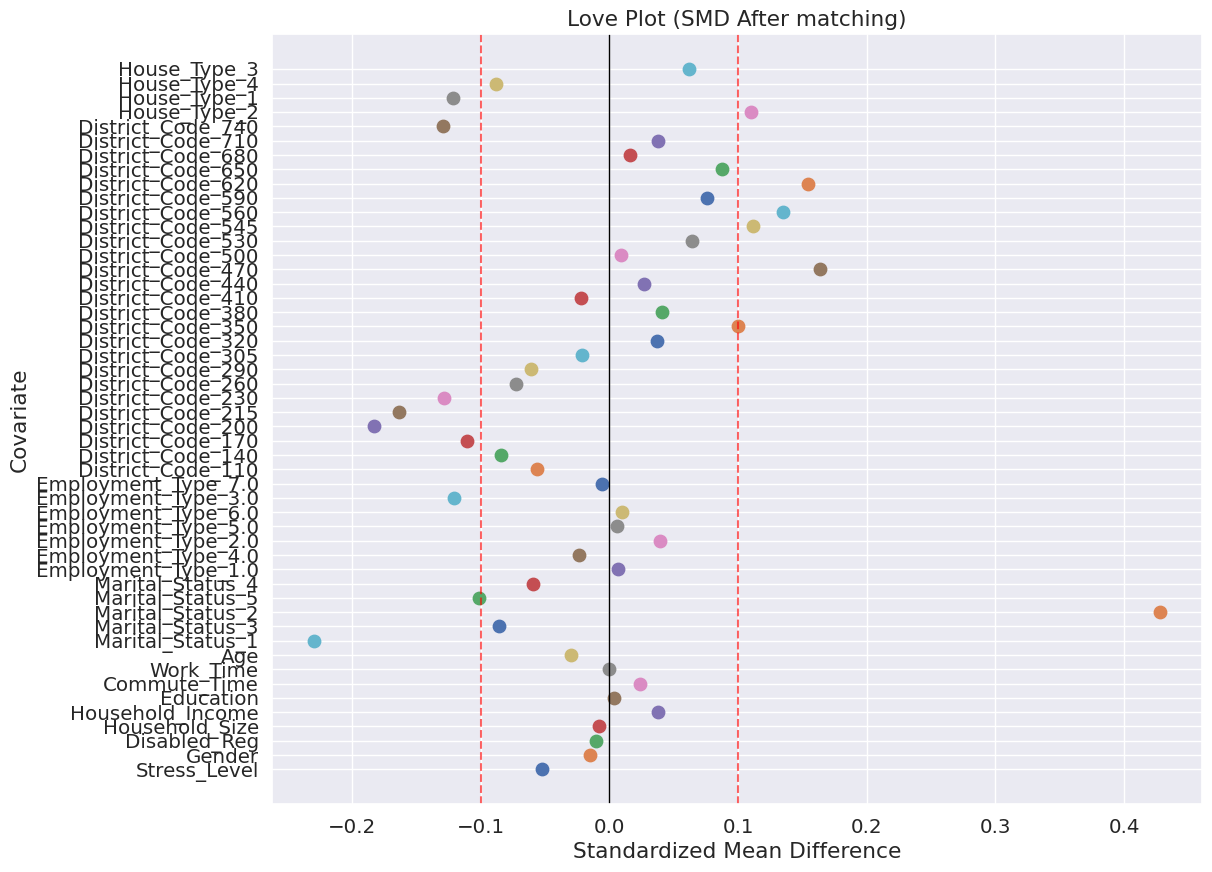

In [69]:
# 매칭 후 SMD 값
num_vars = ['Stress_Level', 'Gender', 'Disabled_Reg', 'Household_Size', 'Household_Income','Education', 'Commute_Time', 'Work_Time','Age']
cat_vars = ['Marital_Status', 'Employment_Type', 'District_Code', 'House_Type']
smd_output = compute_balance(df_matched, num_vars, cat_vars)

plt.figure(figsize=(12,10))
plt.axvline(0, color='black', linewidth=1)
for i, row in smd_output.iterrows():
    plt.scatter(row["SMD"], row["variable"], s=80)

plt.axvline(0.1, color='red', linestyle='--', alpha=0.6)
plt.axvline(-0.1, color='red', linestyle='--', alpha=0.6)
plt.title("Love Plot (SMD After matching)")
plt.xlabel("Standardized Mean Difference")
plt.ylabel("Covariate")
plt.show()

### 매칭 후 결과

In [74]:
model = smf.ols(
    "Stress_Level ~ Gender + C(Marital_Status) + Disabled_Reg + Household_Size + Household_Income + Education + C(Employment_Type)+ C(District_Code) +  C(House_Type) + House_Occupancy +Commute_Time + Commute_Time:House_Occupancy + Work_Time + Age",
    data = df_matched
).fit(cov_type='cluster', cov_kwds={'groups': df_matched['District_Code']})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Stress_Level   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     2140.
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           1.68e-34
Time:                        03:24:18   Log-Likelihood:                -17212.
No. Observations:               13232   AIC:                         3.452e+04
Df Residuals:                   13184   BIC:                         3.488e+04
Df Model:                          47                                         
Covariance Type:              cluster                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

/home/wagyu0923/miniconda3/envs/commuting/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 23
  warnings.warn('covariance of constraints does not have full '
